In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import numpy as np
import random

num_seed = 2019
random.seed(num_seed)
torch.manual_seed(num_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
batch_size = 512
latent_dim = 100
img_size = 64
num_epochs = 100
ndf = 64
ngf = 64
nc = 1

In [0]:
transform = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = dset.FashionMNIST(root='../data/', train=True, transform=transform, download=True)
test_dataset = dset.FashionMNIST(root='../data/', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [0]:
def latent_z(batch_size = 1, latent_dim = 100):
    return torch.randn(batch_size, latent_dim, 1, 1, device=device)

def weights_init_normal(model):
    classname = model.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.constant_(model.bias.data, 0.0)

In [0]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
  
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, img):
        return self.model(img)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            if bn:
                block=[
                    nn.Conv2d(in_filters, out_filters, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_filters),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block=[
                    nn.Conv2d(in_filters, out_filters, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block


        self.model = nn.Sequential(
            *discriminator_block(nc, ndf, bn=False),
            *discriminator_block(ndf, ndf*2),
            *discriminator_block(ndf*2, ndf*4),
            *discriminator_block(ndf*4, ndf*8),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = self.model(img)
        return img

In [6]:
G = Generator().to(device)
D = Discriminator().to(device)

G.apply(weights_init_normal)
D.apply(weights_init_normal)

print(G, D)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [0]:
optimizer_g = optim.Adam(G.parameters(), lr=0.0002)
optimizer_d = optim.Adam(D.parameters(), lr=0.0002)
criterion = nn.BCELoss()

In [0]:
def train(G, D, _optimizer_g, _optimizer_d):
    G.zero_grad()
    D.zero_grad()
    G.train()
    D.train()

    for img_batch, _ in train_loader:
        img_batch = img_batch.to(device)

        _optimizer_d.zero_grad()

        #p_real = D(img_batch) #(512, 1, 1, 1)
        p_real = D(img_batch).view(-1) #512
        p_fake = D(G(latent_z(batch_size, latent_dim))).view(-1)

        D_loss_real = criterion(p_real, torch.ones_like(p_real).to(device))
        D_loss_fake = criterion(p_fake, torch.zeros_like(p_fake).to(device))
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()

        _optimizer_d.step()


        _optimizer_g.zero_grad()
        
        p_fake = D(G(latent_z(batch_size, latent_dim))).view(-1)
        G_loss = criterion(p_fake, torch.ones_like(p_fake).to(device))
        G_loss.backward()

        _optimizer_g.step()

    return D_loss, G_loss

In [9]:
test_num = test_dataset.train_data.size(0)

def evaluate_model(G, D):
    p_real, p_fake = 0., 0. 

    G.eval()
    D.eval()

    for img_batch, _ in test_loader:
        img_batch = img_batch.to(device)

        with torch.autograd.no_grad():
            p_real += (torch.sum(D(img_batch)).item()) / float(test_num)
            p_fake += (torch.sum(D(G(latent_z(batch_size, latent_dim)))).item()) / float(test_num)

    return p_real, p_fake

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [0]:
def imshow_grid(img):
    img = torchvision.utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    img_numpy = img.numpy()
    plt.imshow(np.transpose(img_numpy, (1, 2, 0)))
    plt.show()

(epoch 1/50)	Loss_D: 0.0201	Loss_G: 8.6129 p_real: 0.009114, p_g: 0.949073


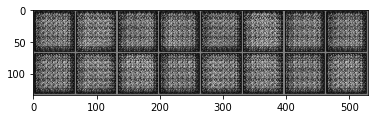

(epoch 2/50)	Loss_D: 0.0346	Loss_G: 7.5121 p_real: 0.236987, p_g: 0.480212


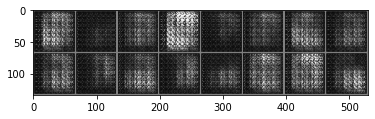

(epoch 3/50)	Loss_D: 0.0415	Loss_G: 7.2023 p_real: 0.351258, p_g: 0.028518


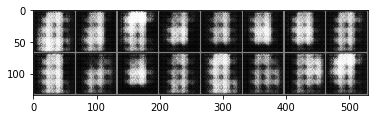

(epoch 4/50)	Loss_D: 0.0343	Loss_G: 6.4618 p_real: 0.850544, p_g: 0.022363


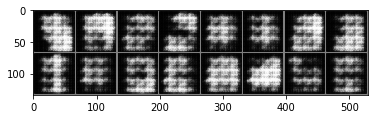

(epoch 5/50)	Loss_D: 0.0289	Loss_G: 8.1438 p_real: 0.114173, p_g: 0.110449


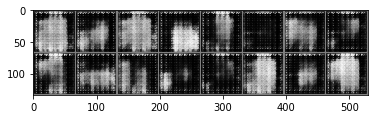

(epoch 6/50)	Loss_D: 0.0115	Loss_G: 7.4742 p_real: 0.648536, p_g: 0.032924


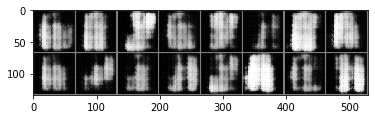

(epoch 7/50)	Loss_D: 0.0637	Loss_G: 7.6134 p_real: 0.863288, p_g: 0.069494


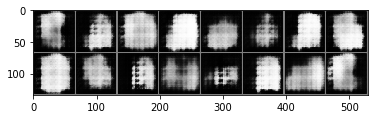

(epoch 8/50)	Loss_D: 0.1832	Loss_G: 4.4459 p_real: 0.973364, p_g: 0.026940


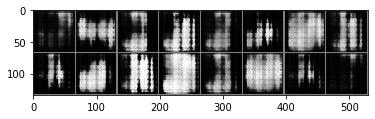

(epoch 9/50)	Loss_D: 0.0281	Loss_G: 5.5655 p_real: 0.888564, p_g: 0.012294


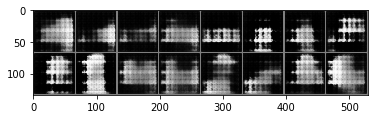

(epoch 10/50)	Loss_D: 0.0922	Loss_G: 4.0781 p_real: 0.947369, p_g: 0.248040


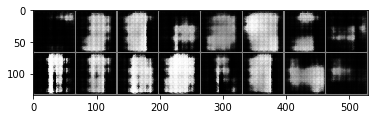

(epoch 11/50)	Loss_D: 0.0407	Loss_G: 6.4309 p_real: 0.876428, p_g: 0.159460


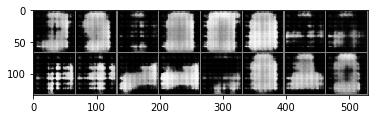

(epoch 12/50)	Loss_D: 0.0219	Loss_G: 7.5208 p_real: 0.704447, p_g: 0.002537


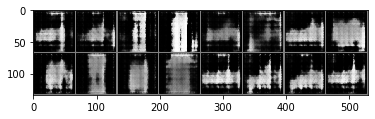

(epoch 13/50)	Loss_D: 0.1133	Loss_G: 4.2782 p_real: 0.991259, p_g: 0.494975


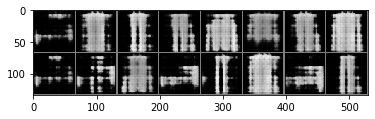

(epoch 14/50)	Loss_D: 0.0334	Loss_G: 6.5490 p_real: 0.806558, p_g: 0.045751


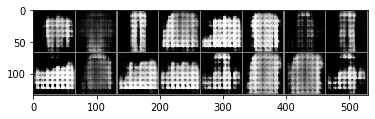

(epoch 15/50)	Loss_D: 0.0274	Loss_G: 6.5472 p_real: 0.653527, p_g: 0.080220


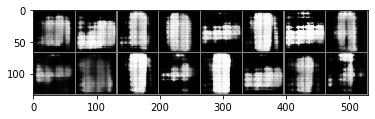

(epoch 16/50)	Loss_D: 0.0390	Loss_G: 6.4556 p_real: 0.847816, p_g: 0.059219


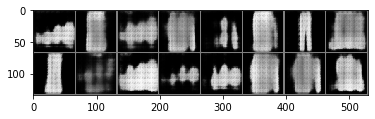

(epoch 17/50)	Loss_D: 0.0098	Loss_G: 8.5431 p_real: 0.455688, p_g: 0.008316


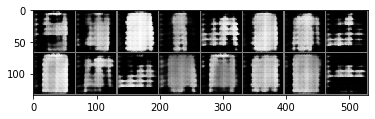

(epoch 18/50)	Loss_D: 0.0661	Loss_G: 5.6219 p_real: 0.791484, p_g: 0.079761


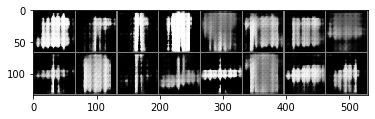

(epoch 19/50)	Loss_D: 0.0110	Loss_G: 6.2939 p_real: 0.565502, p_g: 0.062392


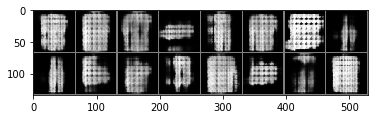

(epoch 20/50)	Loss_D: 0.0942	Loss_G: 4.7541 p_real: 0.857079, p_g: 0.035731


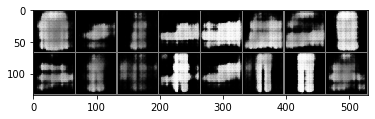

KeyboardInterrupt: ignored

In [11]:
p_real_trace = list()
p_fake_trace = list()
D_losses = list()
G_losses = list()

for epoch in range(num_epochs):
    D_loss, G_loss = train(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G, D)

    p_real_trace.append(p_real) # evaluate 과정이며, 훈련이 된 GAN 모델을 이용해서 진짜 이미지일 확률 분포 값을 의미.
    p_fake_trace.append(p_fake) # evaluate 과정이며, 훈련이 된 GAN 모델을 이용해서 가짜 이미지일 확률 분포 값을 의미.
    D_losses.append(D_loss)
    G_losses.append(G_loss)

    print('(epoch %i/50)\tLoss_D: %.4f\tLoss_G: %.4f p_real: %f, p_g: %f' % (epoch+1, D_loss.item(), G_loss.item(), p_real, p_fake))
    imshow_grid(G(latent_z(16)))

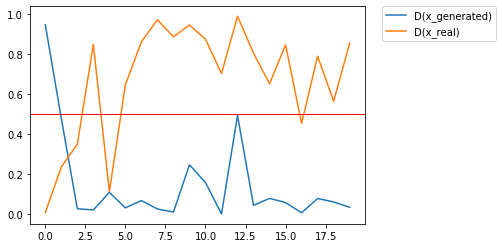

In [15]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.axhline(y=0.5, color='r', linewidth=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

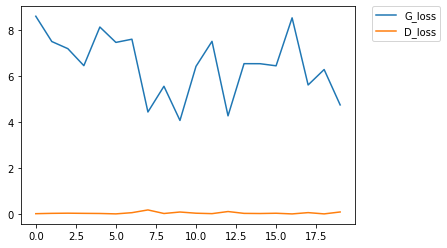

In [17]:
plt.plot(G_losses, label='G_loss')
plt.plot(D_losses, label='D_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

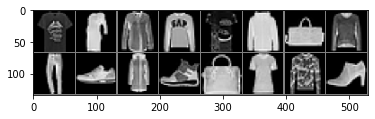

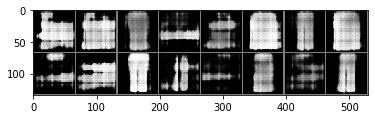

In [18]:
vis_loader = torch.utils.data.DataLoader(test_dataset, 16, True)
img_vis, label_vis   = next(iter(vis_loader))
imshow_grid(img_vis)

imshow_grid(G(latent_z(16,100)).view(-1, 1, 64, 64))